In [131]:
import mxnet as mx
import gluonnlp as nlp

import matplotlib.pyplot as plt
import numpy as np
import os
import random
import sacremoses
import time
from tqdm.notebook import tqdm
import io
from importlib import reload

# Local Libraries
import nmt
import dataprocessor
import utils
import nmt.transformer_hparams
import transformer_model

# Hyperparameters for Dataloaders and Training
hparams = nmt.transformer_hparams

# Seeds for reproducibility
np.random.seed(100)
random.seed(100)
mx.random.seed(100)

# CPU setup
# ctx = mx.cpu()
# Single GPU setup
ctx = mx.gpu(0)

In [192]:
# WMT2016 Dataset
src_lang, tgt_lang = "en", "de"

wmt2016_train_data = nlp.data.WMT2016BPE(
    'train',
    src_lang=src_lang,
    tgt_lang=tgt_lang)

wmt2016_val_data = nlp.data.WMT2016BPE(
    'newstest2016',
    src_lang=src_lang,
    tgt_lang=tgt_lang)

wmt2016_test_data = nlp.data.WMT2016BPE(
    'newstest2016',
    src_lang=src_lang,
    tgt_lang=tgt_lang)

# Text sentences for evaluation
wmt2016_val_text = nlp.data.WMT2016(
    'newstest2016',
    src_lang=src_lang,
    tgt_lang=tgt_lang)

wmt2016_test_text = nlp.data.WMT2016(
    'newstest2016',
    src_lang=src_lang,
    tgt_lang=tgt_lang)

src_max_len, tgt_max_len = 50, 50

In [194]:
# Train data test
# train_length = 500000
# wmt2016_train_data._data[0] = wmt2016_train_data._data[0][:train_length]
# wmt2016_train_data._data[1] = wmt2016_train_data._data[1][:train_length]
# wmt2016_train_data._length = train_length

# Split Val / Test sets
val_length = 1500
test_length = len(wmt2016_test_text) - val_length

wmt2016_val_data._data[0] = wmt2016_val_data._data[0][:val_length]
wmt2016_val_data._data[1] = wmt2016_val_data._data[1][:val_length]
wmt2016_val_data._length = val_length

wmt2016_val_text._data[0] = wmt2016_val_text._data[0][:val_length]
wmt2016_val_text._data[1] = wmt2016_val_text._data[1][:val_length]
wmt2016_val_text._length = val_length

wmt2016_test_data._data[0] = wmt2016_test_data._data[0][-test_length:]
wmt2016_test_data._data[1] = wmt2016_test_data._data[1][-test_length:]
wmt2016_test_data._length = test_length

wmt2016_test_text._data[0] = wmt2016_test_text._data[0][-test_length:]
wmt2016_test_text._data[1] = wmt2016_test_text._data[1][-test_length:]
wmt2016_test_text._length = test_length

In [195]:
print("Length of train set:", len(wmt2016_train_data))
print("Length of val set  :", len(wmt2016_val_data))
print("Length of test set :", len(wmt2016_test_data))

Length of train set: 4500966
Length of val set  : 1500
Length of test set : 1499


In [145]:
wmt2016_val_tgt_sentences = wmt2016_val_text.transform(lambda src, tgt: tgt)
wmt2016_test_tgt_sentences = wmt2016_test_text.transform(lambda src, tgt: tgt)

In [146]:
reload(transformer_model)

# For vocab
wmt_model_name = "transformer_en_de_512"
_, wmt_src_vocab, wmt_tgt_vocab = nlp.model.get_model(
    wmt_model_name,
    dataset_name='WMT2014',
    pretrained=True,
    ctx=ctx)

# Pre-processing WMT2016 with WMT2016 vocab
# Training from scratch
wmt_transform_fn = dataprocessor.TrainValDataTransform(
    # wmt2016_train_data.src_vocab,
    # wmt2016_train_data.tgt_vocab,
    wmt_src_vocab,
    wmt_tgt_vocab,
    src_max_len,
    tgt_max_len)

wmt2016_train_data_processed = wmt2016_train_data.transform(
    wmt_transform_fn,
    lazy=False)

wmt2016_val_data_processed = wmt2016_val_data.transform(
    wmt_transform_fn,
    lazy=False)

wmt2016_test_data_processed = wmt2016_test_data.transform(
    wmt_transform_fn,
    lazy=False)

wmt2016_train_data_lengths = transformer_model.get_data_lengths(wmt2016_train_data_processed)
wmt2016_val_data_lengths = transformer_model.get_data_lengths(wmt2016_val_data_processed)
wmt2016_test_data_lengths = transformer_model.get_data_lengths(wmt2016_test_data_processed)

/home/andreto/.local/lib/python3.8/site-packages/gluonnlp/vocab/vocab.py:590: UserWarning: Detected a corrupted index in the deserialize vocabulary. For versions before GluonNLP v0.7 the index is corrupted by specifying the same token for different special purposes, for example eos_token == padding_token. Deserializing the vocabulary nevertheless.
  warnings.warn(


In [147]:
# Add Lengths to the datasets and indexes for validation and test
wmt2016_train_data_len_processed = wmt2016_train_data_processed.transform(lambda src, tgt: (src, tgt, len(src), len(tgt)), lazy=False)
wmt2016_val_data_len_processed = wmt2016_val_data_processed.transform(transformer_model.get_length_index_fn(), lazy=False)
wmt2016_test_data_len_processed = wmt2016_test_data_processed.transform(transformer_model.get_length_index_fn(), lazy=False)

In [148]:
train_batchify_fn = nlp.data.batchify.Tuple(
    nlp.data.batchify.Pad(pad_val=0),
    nlp.data.batchify.Pad(pad_val=0),
    nlp.data.batchify.Stack(dtype='float32'),
    nlp.data.batchify.Stack(dtype='float32'))

val_batchify_fn = nlp.data.batchify.Tuple(
    nlp.data.batchify.Pad(pad_val=0),
    nlp.data.batchify.Pad(pad_val=0),
    nlp.data.batchify.Stack(dtype='float32'),
    nlp.data.batchify.Stack(dtype='float32'),
    nlp.data.batchify.Stack())

In [149]:
reload(transformer_model)

bucket_scheme = nlp.data.ExpWidthBucket(bucket_len_step=1.2)

wmt2016_train_batch_sampler = nlp.data.FixedBucketSampler(
    lengths=wmt2016_train_data_lengths,
    use_average_length=True, # control the element lengths (i.e. number of tokens) to be about the same
    num_buckets=hparams.num_buckets,
    bucket_scheme=bucket_scheme,
    batch_size=hparams.batch_size,
    shuffle=True)
print(wmt2016_train_batch_sampler.stats())

wmt2016_val_batch_sampler = nlp.data.FixedBucketSampler(
    lengths=wmt2016_val_data_lengths,
    use_average_length=True, # control the element lengths (i.e. number of tokens) to be about the same
    num_buckets=hparams.num_buckets,
    bucket_scheme=bucket_scheme,
    batch_size=hparams.batch_size,
    shuffle=False)
print(wmt2016_val_batch_sampler.stats())

wmt2016_test_batch_sampler = nlp.data.FixedBucketSampler(
    lengths=wmt2016_test_data_lengths,
    use_average_length=True, # control the element lengths (i.e. number of tokens) to be about the same
    num_buckets=hparams.num_buckets,
    bucket_scheme=bucket_scheme,
    batch_size=hparams.batch_size,
    shuffle=False)
print(wmt2016_test_batch_sampler.stats())

FixedBucketSampler:
  sample_num=1500, batch_num=226
  key=[(9, 10), (16, 18), (26, 27), (37, 39), (51, 52)]
  cnt=[63, 236, 362, 363, 476]
  batch_size=[27, 16, 10, 7, 4]
FixedBucketSampler:
  sample_num=150, batch_num=22
  key=[(12, 14), (19, 21), (28, 30), (38, 40), (51, 52)]
  cnt=[27, 29, 28, 24, 42]
  batch_size=[20, 13, 9, 7, 5]
FixedBucketSampler:
  sample_num=2849, batch_num=350
  key=[(10, 11), (18, 19), (27, 28), (38, 39), (51, 52)]
  cnt=[142, 659, 751, 634, 663]
  batch_size=[25, 15, 10, 7, 5]


In [150]:
num_workers = 0

wmt2016_train_data_loader = nlp.data.ShardedDataLoader(
    wmt2016_train_data_len_processed,
    batch_sampler=wmt2016_train_batch_sampler,
    batchify_fn=train_batchify_fn,
    num_workers=num_workers)

wmt2016_val_data_loader = nlp.data.ShardedDataLoader(
    wmt2016_val_data_len_processed,
    batch_sampler=wmt2016_val_batch_sampler,
    batchify_fn=val_batchify_fn,
    num_workers=num_workers,
    shuffle=False)

wmt2016_test_data_loader = nlp.data.ShardedDataLoader(
    wmt2016_test_data_len_processed,
    batch_sampler=wmt2016_test_batch_sampler,
    batchify_fn=val_batchify_fn,
    num_workers=num_workers,
    shuffle=False)

## Training from scratch

In [151]:
# Updates for this recipe
reload(nmt)
hparams = nmt.transformer_hparams

hparams.num_hidden = 512
# hparams.num_layers = 4
# hparams.dropout = 0.2
# hparams.num_buckets = 5
hparams.lr = 0.0001
#hparams.lr = 0.0001
#hparams.lr = 0.0003 achieves 21.44 test_bleu: qualitative evaluation didn't work
#hparams.lr = 0.0001 achieves 19.66 test_bleu: qualitative evaluation worked
# hparams.clip = 5
# hparams.epochs = 12
# hparams.beam_size = 10
# hparams.lp_alpha = 1.0
# hparams.lp_k = 5

# hparams.max_length = 150
# hparams.batch_size = 256

hparams.epochs = 10
hparams.log_interval = 100

In [154]:
# Transformer Model
transformer_encoder, transformer_decoder, transformer_one_step_ahead_decoder = nlp.model.transformer.get_transformer_encoder_decoder(
    hidden_size=hparams.num_hidden,
    dropout=hparams.dropout,
    num_layers=hparams.num_layers)

transformer_model_ts = nlp.model.translation.NMTModel(
    src_vocab=wmt2016_train_data.src_vocab,
    tgt_vocab=wmt2016_train_data.tgt_vocab,
    # src_vocab=wmt_src_vocab,
    # tgt_vocab=wmt_tgt_vocab,
    encoder=transformer_encoder,
    decoder=transformer_decoder,
    one_step_ahead_decoder=transformer_one_step_ahead_decoder,
    #embed_size=hparams.num_hidden,
    embed_size=hparams.num_units,
    prefix='transformer_')

transformer_model_ts.initialize(init=mx.init.Xavier(magnitude=1.0), ctx=ctx)
transformer_model_ts.hybridize(static_alloc=True)

# Translator (using model defined above)
transformer_ts_translator = nmt.translation.BeamSearchTranslator(
    model=transformer_model_ts,
    beam_size=hparams.beam_size,
    scorer=nlp.model.BeamSearchScorer(
        alpha=hparams.lp_alpha,
        K=hparams.lp_k),
    # max_length=150)
    max_length=200)

loss_function = nlp.loss.MaskedSoftmaxCELoss()
loss_function.hybridize(static_alloc=True)

wmt_detokenizer = nlp.data.SacreMosesDetokenizer()

model_filename_ts = "transformer_en_de_512_ts.params"

In [155]:
reload(transformer_model)

# Let's train
trainer = mx.gluon.Trainer(transformer_model_ts.collect_params(), hparams.optimizer, {'learning_rate': hparams.lr})

# # XXXXXXX TEST XXXXXXX
# wmt2016_val_data_loader = wmt2016_test_data_loader
# wmt2016_val_tgt_sentences = wmt2016_test_tgt_sentences

# # XXXXXXX TEST XXXXXXX

best_valid_bleu = 0.0

wmt2016_train_losses = []
wmt2016_valid_losses = []
wmt2016_valid_bleus  = []
wmt2016_valid_perplexities = []

for epoch_id in tqdm(range(hparams.epochs)):

    acc_train_loss_batch = 0
    log_loss = 0
    log_denom = 0
    log_avg_gnorm = 0
    log_wc = 0
    log_start_time = time.time()

    # Iterate through each batch
    for batch_id, (src_seq, tgt_seq, src_valid_length, tgt_valid_length) in enumerate(tqdm(wmt2016_train_data_loader)):
        
        src_seq = src_seq.as_in_context(ctx)
        tgt_seq = tgt_seq.as_in_context(ctx)
        src_valid_length = src_valid_length.as_in_context(ctx)
        tgt_valid_length = tgt_valid_length.as_in_context(ctx)
        
        with mx.autograd.record():
            out, _ = transformer_model_ts(
                src_seq,
                tgt_seq[:, :-1],
                src_valid_length,
                tgt_valid_length - 1)

            loss = loss_function(out, tgt_seq[:, 1:], tgt_valid_length - 1).mean()
            loss = loss * (tgt_seq.shape[1] - 1)
            log_loss += loss * tgt_seq.shape[0]
            log_denom += (tgt_valid_length - 1).sum()
            loss = loss / (tgt_valid_length - 1).mean()
            loss.backward()

        grads = [p.grad(ctx) for p in transformer_model_ts.collect_params().values() if p.grad_req != 'null']
        gnorm = mx.gluon.utils.clip_global_norm(grads, hparams.clip)
        trainer.step(1)
        
        src_wc = src_valid_length.sum().asscalar()
        tgt_wc = (tgt_valid_length - 1).sum().asscalar()
        log_loss = log_loss.asscalar()
        log_denom = log_denom.asscalar()
        log_avg_gnorm += gnorm
        log_wc += src_wc + tgt_wc
        
        train_loss = log_loss / log_denom
        acc_train_loss_batch += train_loss
        
        if (batch_id + 1) % hparams.log_interval == 0:
            wps = log_wc / (time.time() - log_start_time)
            print("[Epoch {} Batch {}/{}] loss={:.4f}, ppl={:.4f}, gnorm={:.4f}, "
                         "throughput={:.2f}K wps, wc={:.2f}K"
                         .format(epoch_id, batch_id + 1, len(wmt2016_train_data_loader),
                                 train_loss,
                                 np.exp(log_loss / log_denom),
                                 log_avg_gnorm / hparams.log_interval,
                                 wps / 1000, log_wc / 1000))
            
            log_start_time = time.time()
            log_loss = 0
            log_denom = 0
            log_avg_gnorm = 0
            log_wc = 0

    wmt2016_train_loss = acc_train_loss_batch / len(wmt2016_train_data_loader)
    wmt2016_train_losses.append(wmt2016_train_loss)
    
    # Validation step
    wmt2016_valid_loss, wmt2016_valid_translation_out = transformer_model.evaluate(
        transformer_model_ts,
        wmt2016_val_data_loader,
        loss_function,
        transformer_ts_translator,
        # wmt2016_train_data.tgt_vocab,
        wmt_tgt_vocab,
        wmt_detokenizer,
        ctx)
    
    wmt2016_valid_bleu_score, _, _, _, _ = nmt.bleu.compute_bleu(
        [wmt2016_val_tgt_sentences],
        wmt2016_valid_translation_out,
        tokenized=False,
        tokenizer="13a",
        split_compound_word=False,
        bpe=False)

    wmt2016_valid_perplexity = np.exp(wmt2016_valid_loss)
    wmt2016_valid_perplexities.append(wmt2016_valid_perplexity)
    wmt2016_valid_losses.append(wmt2016_valid_loss)
    wmt2016_valid_bleus.append(wmt2016_valid_bleu_score * 100)
    
    print("[Epoch {}] valid Loss={:.4f}, valid ppl={:.4f}, valid bleu={:.2f}"
          .format(epoch_id, wmt2016_valid_loss, wmt2016_valid_perplexity, wmt2016_valid_bleu_score * 100))
    
    if wmt2016_valid_bleu_score > best_valid_bleu:
        best_valid_bleu = wmt2016_valid_bleu_score
        print("Save best parameters to {}".format(model_filename_ts))
        transformer_model_ts.save_parameters(model_filename_ts)
    
    # if epoch_id + 1 >= (hparams.epochs * 2) // 3:
    #     new_lr = trainer.learning_rate * hparams.lr_update_factor
    #     print("Learning rate change to {}".format(new_lr))
    #     trainer.set_learning_rate(new_lr)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 0 Batch 100/226] loss=8.4977, ppl=4903.3550, gnorm=2.4728, throughput=8.15K wps, wc=37.81K
[Epoch 0 Batch 200/226] loss=7.1909, ppl=1327.2642, gnorm=1.8666, throughput=9.09K wps, wc=38.11K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 1 Batch 100/226] loss=6.5821, ppl=722.0419, gnorm=1.8682, throughput=8.76K wps, wc=37.96K
[Epoch 1 Batch 200/226] loss=6.4652, ppl=642.4189, gnorm=1.8462, throughput=8.91K wps, wc=38.07K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 2 Batch 100/226] loss=6.1089, ppl=449.8357, gnorm=1.8867, throughput=8.74K wps, wc=37.67K
[Epoch 2 Batch 200/226] loss=5.9710, ppl=391.9001, gnorm=1.9454, throughput=8.55K wps, wc=38.07K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 3 Batch 100/226] loss=5.6792, ppl=292.7240, gnorm=2.0004, throughput=9.11K wps, wc=38.30K
[Epoch 3 Batch 200/226] loss=5.6309, ppl=278.9216, gnorm=2.0285, throughput=8.86K wps, wc=38.06K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 4 Batch 100/226] loss=5.3394, ppl=208.3903, gnorm=2.0630, throughput=8.98K wps, wc=38.10K
[Epoch 4 Batch 200/226] loss=5.2548, ppl=191.4915, gnorm=2.1968, throughput=8.93K wps, wc=37.57K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 5 Batch 100/226] loss=5.0007, ppl=148.5223, gnorm=2.2029, throughput=8.81K wps, wc=37.73K
[Epoch 5 Batch 200/226] loss=4.9333, ppl=138.8388, gnorm=2.2370, throughput=9.04K wps, wc=37.97K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 6 Batch 100/226] loss=4.6335, ppl=102.8709, gnorm=2.2654, throughput=8.86K wps, wc=38.11K
[Epoch 6 Batch 200/226] loss=4.6623, ppl=105.8757, gnorm=2.3430, throughput=8.92K wps, wc=37.98K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 7 Batch 100/226] loss=4.3719, ppl=79.1938, gnorm=2.3566, throughput=8.79K wps, wc=38.07K
[Epoch 7 Batch 200/226] loss=4.3558, ppl=77.9258, gnorm=2.4839, throughput=8.89K wps, wc=38.04K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 8 Batch 100/226] loss=4.1091, ppl=60.8946, gnorm=2.4751, throughput=8.47K wps, wc=37.47K
[Epoch 8 Batch 200/226] loss=4.0203, ppl=55.7171, gnorm=2.5297, throughput=9.07K wps, wc=38.41K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 9 Batch 100/226] loss=3.7868, ppl=44.1146, gnorm=2.5800, throughput=8.07K wps, wc=37.85K
[Epoch 9 Batch 200/226] loss=3.7837, ppl=43.9791, gnorm=2.6562, throughput=8.73K wps, wc=38.25K


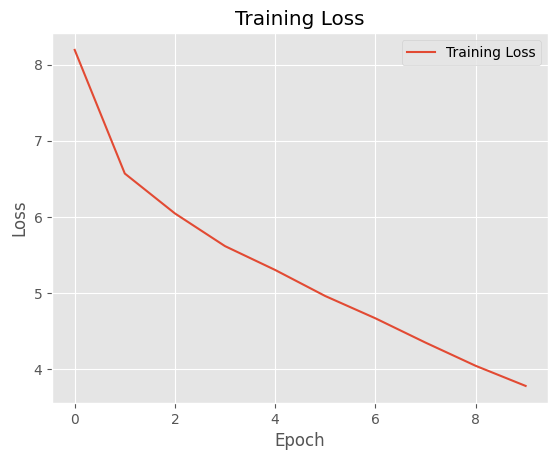

In [157]:
# plot losses and validation accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(range(0, hparams.epochs), wmt2016_train_losses, label="Training Loss")
# plt.plot(range(0, hparams.epochs), wmt2016_valid_losses, label="Validation Loss")
# plt.plot(range(0, hparams.epochs), wmt2016_valid_perplexities, label="Validation Perplexity")
# plt.plot(range(0, hparams.epochs), wmt2016_valid_bleus, label="Validation BLEU")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Training Loss")
plt.show()

In [23]:
transformer_model_ts.load_parameters(model_filename_ts)

wmt2016_test_loss, wmt2016_test_translation_out = transformer_model.evaluate(
    transformer_model_ts,
    wmt2016_test_data_loader,
    loss_function,
    transformer_ts_translator,
    wmt_tgt_vocab,
    wmt_detokenizer,
    ctx)

wmt2016_valid_bleu_score, _, _, _, _ = nmt.bleu.compute_bleu(
    [wmt2016_test_tgt_sentences],
    wmt2016_test_translation_out,
    tokenized=False,
    tokenizer="13a",
    split_compound_word=False,
    bpe=False)

print('WMT16 test loss: %.2f; test bleu score: %.2f'
      %(wmt2016_test_loss, wmt2016_valid_bleu_score * 100))

  0%|          | 0/184 [00:00<?, ?it/s]

WMT16 test loss: 3.01; test bleu score: 14.50


In [28]:
print("Qualitative Evaluation: Translating from English to German")

# From Google Translate
expected_tgt_seq = "Ich lerne jeden Tag neue Dinge."
print("Expected translation:")
print(expected_tgt_seq)

src_seq = "I learn new things every day."
print("In English:")
print(src_seq)

# translation_out = nmt.utils.translate_with_unk(
translation_out = nmt.utils.translate(
    # wmt_translator_tl,
    transformer_ts_translator,
    src_seq,
    # wmt2016_train_data.src_vocab,
    # wmt2016_train_data.tgt_vocab,
    wmt_src_vocab,
    wmt_tgt_vocab,
    ctx)

print("The German translation is:")
print(" ".join(translation_out[0]))

Qualitative Evaluation: Translating from English to German
Expected translation:
Ich lerne jeden Tag neue Dinge.
In English:
I love German so much
The German translation is:
Ich halte es für so , dass es hier so ist , dass es hier so ist , dass es hier ja auch so ist , dass es hier so ist , dass es hier ja auch so ist , dass es hier ja auch so ist , dass hier


## Pre-Trained Model

In [196]:
wmt_model_name = 'transformer_en_de_512'
wmt_transformer_model_pt, wmt_src_vocab, wmt_tgt_vocab = nlp.model.get_model(
    wmt_model_name,
    dataset_name='WMT2014',
    pretrained=True,
    ctx=ctx)

wmt_transformer_model_pt.hybridize(static_alloc=True)

print('Source Vocab:', len(wmt_src_vocab), ', Target Vocab:', len(wmt_tgt_vocab))

/home/andreto/.local/lib/python3.8/site-packages/gluonnlp/vocab/vocab.py:590: UserWarning: Detected a corrupted index in the deserialize vocabulary. For versions before GluonNLP v0.7 the index is corrupted by specifying the same token for different special purposes, for example eos_token == padding_token. Deserializing the vocabulary nevertheless.
  warnings.warn(


Source Vocab: 36794 , Target Vocab: 36794


In [30]:
# Reload data with model vocab
src_lang, tgt_lang = "en", "de"

wmt_data_test = nlp.data.WMT2016BPE(
    'newstest2016',
    src_lang=src_lang,
    tgt_lang=tgt_lang)
print('Sample BPE tokens: "{}"'.format(wmt_data_test[0]))

wmt_test_text = nlp.data.WMT2016(
    'newstest2016',
    src_lang=src_lang,
    tgt_lang=tgt_lang)
print('Sample raw text: "{}"'.format(wmt_test_text[0]))

wmt_test_tgt_sentences = wmt_test_text.transform(lambda src, tgt: tgt)
print('Sample target sentence: "{}"'.format(wmt_test_tgt_sentences[0]))

src_max_len, tgt_max_len = 50, 50

Sample BPE tokens: "('Obama receives Net@@ any@@ ah@@ u', 'Obama empfängt Net@@ any@@ ah@@ u')"
Sample raw text: "('Obama receives Netanyahu', 'Obama empfängt Netanyahu')"
Sample target sentence: "Obama empfängt Netanyahu"


In [31]:
# Pre-processing WMT2016 with WMT2014 model vocab
wmt_dataset_processed = wmt_data_test.transform(
    dataprocessor.TrainValDataTransform(
        wmt_src_vocab,
        wmt_tgt_vocab,
        src_max_len,
        tgt_max_len),
    lazy=False)

# def get_length_index_fn():
#     global idx
#     idx = 0
#     def transform(src, tgt):
#         global idx
#         result = (src, tgt, len(src), len(tgt), idx)
#         idx += 1
#         return result
#     return transform

wmt_data_test_with_len = wmt_dataset_processed.transform(transformer_model.get_length_index_fn(), lazy=False)

In [32]:
wmt_test_batchify_fn = nlp.data.batchify.Tuple(
    nlp.data.batchify.Pad(pad_val=0),
    nlp.data.batchify.Pad(pad_val=0),
    nlp.data.batchify.Stack(dtype='float32'),
    nlp.data.batchify.Stack(dtype='float32'),
    nlp.data.batchify.Stack())

In [33]:
wmt_bucket_scheme = nlp.data.ExpWidthBucket(bucket_len_step=1.2)
wmt_test_batch_sampler = nlp.data.FixedBucketSampler(
    lengths=wmt_data_test_with_len.transform(lambda src, tgt, src_len, tgt_len, idx: tgt_len), # target length
    use_average_length=True, # control the element lengths (i.e. number of tokens) to be about the same
    bucket_scheme=wmt_bucket_scheme,
    batch_size=hparams.batch_size)
print(wmt_test_batch_sampler.stats())

FixedBucketSampler:
  sample_num=2999, batch_num=390
  key=[7, 9, 12, 15, 18, 23, 28, 35, 43, 52]
  cnt=[26, 67, 169, 275, 302, 435, 421, 442, 355, 507]
  batch_size=[36, 28, 21, 17, 14, 11, 9, 7, 6, 4]


In [34]:
num_workers=0

wmt_test_data_loader = mx.gluon.data.DataLoader(
    wmt_data_test_with_len,
    batch_sampler=wmt_test_batch_sampler,
    batchify_fn=wmt_test_batchify_fn,
    num_workers=num_workers)
len(wmt_test_data_loader)

390

In [35]:
transformer_pt_translator = nmt.translation.BeamSearchTranslator(
    model=wmt_transformer_model_pt,
    beam_size=hparams.beam_size,
    scorer=nlp.model.BeamSearchScorer(alpha=hparams.lp_alpha, K=hparams.lp_k),
    max_length=200)

wmt_test_loss_function = nlp.loss.MaskedSoftmaxCELoss()
wmt_test_loss_function.hybridize()

wmt_detokenizer = nlp.data.SacreMosesDetokenizer()

In [36]:
reload(transformer_model)

wmt_test_loss, wmt_test_translation_out = transformer_model.evaluate(
    wmt_transformer_model_pt,
    wmt_test_data_loader,
    wmt_test_loss_function,
    transformer_pt_translator,
    wmt_tgt_vocab,
    wmt_detokenizer,
    ctx)

wmt_test_bleu_score, _, _, _, _ = nmt.bleu.compute_bleu(
    [wmt_test_tgt_sentences],
    wmt_test_translation_out,
    tokenized=False,
    tokenizer="13a",
    split_compound_word=False,
    bpe=False)

print('WMT16 test loss: %.2f; test bleu score: %.2f'
      %(wmt_test_loss, wmt_test_bleu_score * 100))

  0%|          | 0/390 [00:00<?, ?it/s]

WMT16 test loss: 1.59; test bleu score: 29.76


In [70]:
reload(transformer_model)

print("Qualitative Evaluation: Translating from English to German")

# From Google Translate
expected_tgt_seq = "Ich lerne jeden Tag neue Dinge."
print("Expected translation:")
print(expected_tgt_seq)

src_seq = "I learn new things every day."
print("In English:")
print(src_seq)

# translation_out = nmt.utils.translate_with_unk(
# translation_out = nmt.utils.translate(
translation_out = transformer_model.translate(
    # wmt_translator_tl,
    transformer_pt_translator,
    src_seq,
    # wmt2016_train_data.src_vocab,
    # wmt2016_train_data.tgt_vocab,
    wmt_src_vocab,
    wmt_tgt_vocab,
    wmt_detokenizer,
    ctx)

print("The German translation is:")
print(" ".join(translation_out[0]))

Qualitative Evaluation: Translating from English to German
Expected translation:
Ich lerne jeden Tag neue Dinge.
In English:
I learn new things every day.
The German translation is:
Ich lerne neue Dinge, die in jedem Fall auftreten.


## Transfer Learning

In [177]:
wmt_transformer_model_tl = wmt_transformer_model_pt

# Freeze Layers (keeping track of the updated parameters)
updated_params = []
for param in wmt_transformer_model_tl.collect_params().values():
    if param.grad_req == "write":
        param.grad_req = "null"
        updated_params += [param.name]

# No need to overwrite last layer, just re-initialize
# wmt_transformer_model_tl.tgt_proj = mx.gluon.nn.Dense(units=len(wmt_tgt_vocab), flatten=False, prefix='tgt_proj_')
wmt_transformer_model_tl.tgt_proj.initialize(ctx=ctx, force_reinit=True)

# Re-enable gradients for last layer
for param in wmt_transformer_model_tl.tgt_proj.collect_params().values():
    if param.name in updated_params:
        param.grad_req = "write"

wmt_transformer_model_tl.hybridize(static_alloc=True)

model_filename_tl = "transformer_en_de_512_tl.params"

In [178]:
wmt_translator_tl = nmt.translation.BeamSearchTranslator(
    model=wmt_transformer_model_tl,
    beam_size=hparams.beam_size,
    scorer=nlp.model.BeamSearchScorer(alpha=hparams.lp_alpha, K=hparams.lp_k),
    max_length=200)

In [179]:
hparams.lr = 0.00001
hparams.epochs = 10


loss_function = nlp.loss.MaskedSoftmaxCELoss()
loss_function.hybridize(static_alloc=True)

wmt_detokenizer = nlp.data.SacreMosesDetokenizer()


In [180]:
reload(transformer_model)

# Let's train
trainer = mx.gluon.Trainer(wmt_transformer_model_tl.collect_params(), hparams.optimizer, {'learning_rate': hparams.lr})

best_valid_bleu = 0.0

wmt2016_train_losses = []
wmt2016_valid_losses = []
wmt2016_valid_bleus  = []
wmt2016_valid_perplexities = []

for epoch_id in tqdm(range(hparams.epochs)):

    acc_train_loss_batch = 0
    log_loss = 0
    log_denom = 0
    log_avg_gnorm = 0
    log_wc = 0
    log_start_time = time.time()

    # Iterate through each batch
    for batch_id, (src_seq, tgt_seq, src_valid_length, tgt_valid_length) in enumerate(tqdm(wmt2016_train_data_loader)):
        
        src_seq = src_seq.as_in_context(ctx)
        tgt_seq = tgt_seq.as_in_context(ctx)
        src_valid_length = src_valid_length.as_in_context(ctx)
        tgt_valid_length = tgt_valid_length.as_in_context(ctx)
        
        with mx.autograd.record():
            out, _ = wmt_transformer_model_tl(
                src_seq,
                tgt_seq[:, :-1],
                src_valid_length,
                tgt_valid_length - 1)

            loss = loss_function(out, tgt_seq[:, 1:], tgt_valid_length - 1).mean()
            loss = loss * (tgt_seq.shape[1] - 1)
            log_loss += loss * tgt_seq.shape[0]
            log_denom += (tgt_valid_length - 1).sum()
            loss = loss / (tgt_valid_length - 1).mean()
            loss.backward()

        grads = [p.grad(ctx) for p in wmt_transformer_model_tl.collect_params().values() if p.grad_req != 'null']
        gnorm = mx.gluon.utils.clip_global_norm(grads, hparams.clip)
        trainer.step(1)
        
        src_wc = src_valid_length.sum().asscalar()
        tgt_wc = (tgt_valid_length - 1).sum().asscalar()
        log_loss = log_loss.asscalar()
        log_denom = log_denom.asscalar()
        log_avg_gnorm += gnorm
        log_wc += src_wc + tgt_wc
        
        train_loss = log_loss / log_denom
        acc_train_loss_batch += train_loss
        
        if (batch_id + 1) % hparams.log_interval == 0:
            wps = log_wc / (time.time() - log_start_time)
            print("[Epoch {} Batch {}/{}] loss={:.4f}, ppl={:.4f}, gnorm={:.4f}, "
                         "throughput={:.2f}K wps, wc={:.2f}K"
                         .format(epoch_id, batch_id + 1, len(wmt2016_train_data_loader),
                                 train_loss,
                                 np.exp(log_loss / log_denom),
                                 log_avg_gnorm / hparams.log_interval,
                                 wps / 1000, log_wc / 1000))
            
            log_start_time = time.time()
            log_loss = 0
            log_denom = 0
            log_avg_gnorm = 0
            log_wc = 0

    wmt2016_train_loss = acc_train_loss_batch / len(wmt2016_train_data_loader)
    wmt2016_train_losses.append(wmt2016_train_loss)
    
    # Validation step
    wmt2016_valid_loss, wmt2016_valid_translation_out = transformer_model.evaluate(
        wmt_transformer_model_tl,
        wmt2016_val_data_loader,
        loss_function,
        wmt_translator_tl,
        # wmt2016_train_data.tgt_vocab,
        wmt_tgt_vocab,
        wmt_detokenizer,
        ctx)
    
    wmt2016_valid_bleu_score, _, _, _, _ = nmt.bleu.compute_bleu(
        [wmt2016_val_tgt_sentences],
        wmt2016_valid_translation_out,
        tokenized=False,
        tokenizer="13a",
        split_compound_word=False,
        bpe=False)

    wmt2016_valid_perplexity = np.exp(wmt2016_valid_loss)
    wmt2016_valid_perplexities.append(wmt2016_valid_perplexity)
    wmt2016_valid_losses.append(wmt2016_valid_loss)
    wmt2016_valid_bleus.append(wmt2016_valid_bleu_score * 100)
    
    print("[Epoch {}] valid Loss={:.4f}, valid ppl={:.4f}, valid bleu={:.2f}"
          .format(epoch_id, wmt2016_valid_loss, wmt2016_valid_perplexity, wmt2016_valid_bleu_score * 100))
    
    if wmt2016_valid_bleu_score > best_valid_bleu:
        best_valid_bleu = wmt2016_valid_bleu_score
        print("Save best parameters to {}".format(model_filename_tl))
        wmt_transformer_model_tl.save_parameters(model_filename_tl)
    
    # if epoch_id + 1 >= (hparams.epochs * 2) // 3:
    #     new_lr = trainer.learning_rate * hparams.lr_update_factor
    #     print("Learning rate change to {}".format(new_lr))
    #     trainer.set_learning_rate(new_lr)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 0 Batch 100/226] loss=10.5754, ppl=39158.1211, gnorm=7.6279, throughput=14.38K wps, wc=37.67K
[Epoch 0 Batch 200/226] loss=10.4199, ppl=33521.2617, gnorm=7.5159, throughput=14.95K wps, wc=38.24K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 1 Batch 100/226] loss=10.2271, ppl=27641.6094, gnorm=8.2685, throughput=14.84K wps, wc=38.26K
[Epoch 1 Batch 200/226] loss=10.0565, ppl=23306.1094, gnorm=8.5255, throughput=14.76K wps, wc=37.69K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 2 Batch 100/226] loss=9.8734, ppl=19407.6133, gnorm=9.3747, throughput=14.66K wps, wc=38.09K
[Epoch 2 Batch 200/226] loss=9.7266, ppl=16756.7070, gnorm=9.3649, throughput=15.06K wps, wc=38.06K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 3 Batch 100/226] loss=9.5591, ppl=14172.5732, gnorm=9.7871, throughput=15.05K wps, wc=37.98K
[Epoch 3 Batch 200/226] loss=9.4301, ppl=12458.1807, gnorm=9.1646, throughput=14.51K wps, wc=37.80K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 4 Batch 100/226] loss=9.2427, ppl=10328.9150, gnorm=10.8450, throughput=13.61K wps, wc=38.67K
[Epoch 4 Batch 200/226] loss=9.1434, ppl=9352.1191, gnorm=10.0248, throughput=14.33K wps, wc=37.26K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 5 Batch 100/226] loss=8.9848, ppl=7980.9272, gnorm=12.3600, throughput=15.00K wps, wc=37.72K
[Epoch 5 Batch 200/226] loss=8.8733, ppl=7138.6274, gnorm=8.9152, throughput=14.45K wps, wc=38.07K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 6 Batch 100/226] loss=8.6991, ppl=5997.5269, gnorm=8.2921, throughput=15.01K wps, wc=37.91K
[Epoch 6 Batch 200/226] loss=8.6310, ppl=5602.7773, gnorm=9.0049, throughput=14.62K wps, wc=38.38K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 7 Batch 100/226] loss=8.4848, ppl=4840.4878, gnorm=13.2777, throughput=14.31K wps, wc=38.10K
[Epoch 7 Batch 200/226] loss=8.3539, ppl=4246.5972, gnorm=6.7909, throughput=14.25K wps, wc=37.85K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 8 Batch 100/226] loss=8.2634, ppl=3879.3354, gnorm=7.9820, throughput=13.77K wps, wc=38.26K
[Epoch 8 Batch 200/226] loss=8.1349, ppl=3411.6279, gnorm=7.3301, throughput=15.00K wps, wc=37.82K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 9 Batch 100/226] loss=8.0587, ppl=3161.2939, gnorm=7.9004, throughput=15.13K wps, wc=38.45K
[Epoch 9 Batch 200/226] loss=7.9618, ppl=2869.2305, gnorm=6.6398, throughput=13.40K wps, wc=37.24K


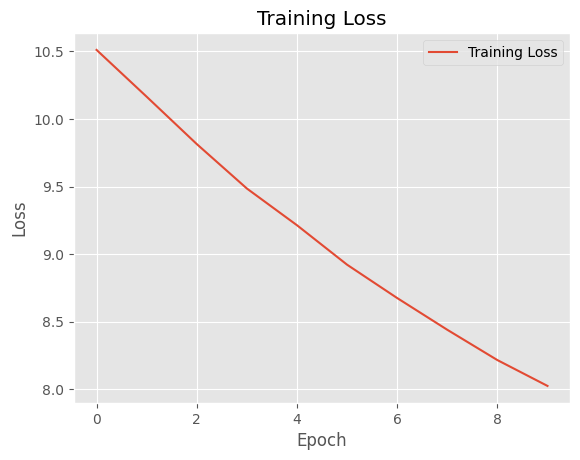

In [181]:
# plot losses and validation accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(range(0, hparams.epochs), wmt2016_train_losses, label="Training Loss")
# plt.plot(range(0, hparams.epochs), wmt2016_valid_losses, label="Validation Loss")
# plt.plot(range(0, hparams.epochs), wmt2016_valid_perplexities, label="Validation Perplexity")
# plt.plot(range(0, hparams.epochs), wmt2016_valid_bleus, label="Validation BLEU")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Training Loss")
plt.show()

In [130]:
# Load best model
wmt_transformer_model_tl.load_parameters(model_filename_tl)

wmt2016_test_loss, wmt2016_test_translation_out = transformer_model.evaluate(
    wmt_transformer_model_tl,
    wmt2016_test_data_loader,
    loss_function,
    wmt_translator_tl,
    wmt_tgt_vocab,
    wmt_detokenizer,
    ctx)

wmt2016_test_bleu_score, _, _, _, _ = nmt.bleu.compute_bleu(
    [wmt2016_test_tgt_sentences],
    wmt2016_test_translation_out,
    tokenized=False,
    tokenizer="13a",
    split_compound_word=False,
    bpe=False)

print('WMT16 test loss: %.2f; test bleu score: %.2f'
      %(wmt2016_test_loss, wmt2016_test_bleu_score * 100))

  0%|          | 0/184 [00:00<?, ?it/s]

WMT16 test loss: 1.20; test bleu score: 27.78


In [93]:
reload(transformer_model)

print("Qualitative Evaluation: Translating from English to German")

# From Google Translate
expected_tgt_seq = "Ich lerne jeden Tag neue Dinge."
print("Expected translation:")
print(expected_tgt_seq)

src_seq = "I learn new things every day."
print("In English:")
print(src_seq)

# translation_out = nmt.utils.translate_with_unk(
# translation_out = nmt.utils.translate(
translation_out = transformer_model.translate(
    wmt_translator_tl,
    src_seq,
    # wmt2016_train_data.src_vocab,
    # wmt2016_train_data.tgt_vocab,
    wmt_src_vocab,
    wmt_tgt_vocab,
    wmt_detokenizer,
    ctx)

print("The German translation is:")
print(" ".join(translation_out[0]))

Qualitative Evaluation: Translating from English to German
Expected translation:
Ich lerne jeden Tag neue Dinge.
In English:
I learn new things every day.
The German translation is:
Ich erlerne jedes Mal neue Dinge


## Fine-Tuning (after Transfer Learning)

In [182]:
# Model built on top of Transfer Learning model
wmt_transformer_model_ft = wmt_transformer_model_tl
wmt_transformer_model_ft.load_parameters(model_filename_tl)

# Un-freeze weights
for param in wmt_transformer_model_ft.collect_params().values(): 
    if param.name in updated_params:
        param.grad_req = 'write'

wmt_transformer_model_ft.hybridize()

model_filename_ft = "transformer_en_de_512_ft.params"

In [183]:
wmt_translator_ft = nmt.translation.BeamSearchTranslator(
    model=wmt_transformer_model_ft,
    beam_size=hparams.beam_size,
    scorer=nlp.model.BeamSearchScorer(alpha=hparams.lp_alpha, K=hparams.lp_k),
    max_length=200)

In [184]:
hparams.epochs = 10
hparams.lr = 0.00003

loss_function = nlp.loss.MaskedSoftmaxCELoss()
loss_function.hybridize(static_alloc=True)

wmt_detokenizer = nlp.data.SacreMosesDetokenizer()

In [185]:
reload(transformer_model)

# Let's train
trainer = mx.gluon.Trainer(wmt_transformer_model_ft.collect_params(), hparams.optimizer, {'learning_rate': hparams.lr})

best_valid_bleu = 0.0

wmt2016_train_losses = []
wmt2016_valid_losses = []
wmt2016_valid_bleus  = []
wmt2016_valid_perplexities = []

for epoch_id in tqdm(range(hparams.epochs)):

    acc_train_loss_batch = 0
    log_loss = 0
    log_denom = 0
    log_avg_gnorm = 0
    log_wc = 0
    log_start_time = time.time()

    # Iterate through each batch
    for batch_id, (src_seq, tgt_seq, src_valid_length, tgt_valid_length) in enumerate(tqdm(wmt2016_train_data_loader)):
        
        src_seq = src_seq.as_in_context(ctx)
        tgt_seq = tgt_seq.as_in_context(ctx)
        src_valid_length = src_valid_length.as_in_context(ctx)
        tgt_valid_length = tgt_valid_length.as_in_context(ctx)
        
        with mx.autograd.record():
            out, _ = wmt_transformer_model_ft(
                src_seq,
                tgt_seq[:, :-1],
                src_valid_length,
                tgt_valid_length - 1)

            loss = loss_function(out, tgt_seq[:, 1:], tgt_valid_length - 1).mean()
            loss = loss * (tgt_seq.shape[1] - 1)
            log_loss += loss * tgt_seq.shape[0]
            log_denom += (tgt_valid_length - 1).sum()
            loss = loss / (tgt_valid_length - 1).mean()
            loss.backward()

        grads = [p.grad(ctx) for p in wmt_transformer_model_ft.collect_params().values() if p.grad_req != 'null']
        gnorm = mx.gluon.utils.clip_global_norm(grads, hparams.clip)
        trainer.step(1)
        
        src_wc = src_valid_length.sum().asscalar()
        tgt_wc = (tgt_valid_length - 1).sum().asscalar()
        log_loss = log_loss.asscalar()
        log_denom = log_denom.asscalar()
        log_avg_gnorm += gnorm
        log_wc += src_wc + tgt_wc
        
        train_loss = log_loss / log_denom
        acc_train_loss_batch += train_loss
        
        if (batch_id + 1) % hparams.log_interval == 0:
            wps = log_wc / (time.time() - log_start_time)
            print("[Epoch {} Batch {}/{}] loss={:.4f}, ppl={:.4f}, gnorm={:.4f}, "
                         "throughput={:.2f}K wps, wc={:.2f}K"
                         .format(epoch_id, batch_id + 1, len(wmt2016_train_data_loader),
                                 train_loss,
                                 np.exp(log_loss / log_denom),
                                 log_avg_gnorm / hparams.log_interval,
                                 wps / 1000, log_wc / 1000))
            
            log_start_time = time.time()
            log_loss = 0
            log_denom = 0
            log_avg_gnorm = 0
            log_wc = 0

    wmt2016_train_loss = acc_train_loss_batch / len(wmt2016_train_data_loader)
    wmt2016_train_losses.append(wmt2016_train_loss)
    
    # Validation step
    wmt2016_valid_loss, wmt2016_valid_translation_out = transformer_model.evaluate(
        wmt_transformer_model_ft,
        wmt2016_val_data_loader,
        loss_function,
        wmt_translator_ft,
        # wmt2016_train_data.tgt_vocab,
        wmt_tgt_vocab,
        wmt_detokenizer,
        ctx)
    
    wmt2016_valid_bleu_score, _, _, _, _ = nmt.bleu.compute_bleu(
        [wmt2016_val_tgt_sentences],
        wmt2016_valid_translation_out,
        tokenized=False,
        tokenizer="13a",
        split_compound_word=False,
        bpe=False)

    wmt2016_valid_perplexity = np.exp(wmt2016_valid_loss)
    wmt2016_valid_perplexities.append(wmt2016_valid_perplexity)
    wmt2016_valid_losses.append(wmt2016_valid_loss)
    wmt2016_valid_bleus.append(wmt2016_valid_bleu_score * 100)
    
    print("[Epoch {}] valid Loss={:.4f}, valid ppl={:.4f}, valid bleu={:.2f}"
          .format(epoch_id, wmt2016_valid_loss, wmt2016_valid_perplexity, wmt2016_valid_bleu_score * 100))
    
    if wmt2016_valid_bleu_score > best_valid_bleu:
        best_valid_bleu = wmt2016_valid_bleu_score
        print("Save best parameters to {}".format(model_filename_ft))
        wmt_transformer_model_ft.save_parameters(model_filename_ft)
    
    # if epoch_id + 1 >= (hparams.epochs * 2) // 3:
    #     new_lr = trainer.learning_rate * hparams.lr_update_factor
    #     print("Learning rate change to {}".format(new_lr))
    #     trainer.set_learning_rate(new_lr)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 0 Batch 100/226] loss=1.3049, ppl=3.6873, gnorm=4.3469, throughput=6.70K wps, wc=37.46K
[Epoch 0 Batch 200/226] loss=1.2621, ppl=3.5327, gnorm=4.2847, throughput=6.86K wps, wc=38.50K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 1 Batch 100/226] loss=1.1073, ppl=3.0263, gnorm=4.0800, throughput=6.33K wps, wc=37.75K
[Epoch 1 Batch 200/226] loss=1.1070, ppl=3.0252, gnorm=4.0733, throughput=6.43K wps, wc=38.24K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 2 Batch 100/226] loss=0.9501, ppl=2.5859, gnorm=3.9402, throughput=6.14K wps, wc=37.44K
[Epoch 2 Batch 200/226] loss=0.9870, ppl=2.6832, gnorm=4.1110, throughput=6.14K wps, wc=38.21K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 3 Batch 100/226] loss=0.8315, ppl=2.2968, gnorm=3.7676, throughput=6.32K wps, wc=38.17K
[Epoch 3 Batch 200/226] loss=0.8700, ppl=2.3870, gnorm=4.1085, throughput=6.46K wps, wc=38.09K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 4 Batch 100/226] loss=0.7449, ppl=2.1062, gnorm=3.9107, throughput=6.14K wps, wc=38.16K
[Epoch 4 Batch 200/226] loss=0.7539, ppl=2.1254, gnorm=4.0711, throughput=6.37K wps, wc=37.67K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 5 Batch 100/226] loss=0.6459, ppl=1.9077, gnorm=3.7458, throughput=6.30K wps, wc=38.40K
[Epoch 5 Batch 200/226] loss=0.6527, ppl=1.9206, gnorm=3.8702, throughput=6.35K wps, wc=37.18K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 6 Batch 100/226] loss=0.5630, ppl=1.7560, gnorm=3.7190, throughput=6.43K wps, wc=37.87K
[Epoch 6 Batch 200/226] loss=0.5614, ppl=1.7531, gnorm=3.7096, throughput=6.37K wps, wc=38.30K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 7 Batch 100/226] loss=0.4826, ppl=1.6203, gnorm=3.5831, throughput=6.38K wps, wc=37.98K
[Epoch 7 Batch 200/226] loss=0.4991, ppl=1.6473, gnorm=3.6921, throughput=6.43K wps, wc=38.13K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 8 Batch 100/226] loss=0.4199, ppl=1.5218, gnorm=3.5668, throughput=6.32K wps, wc=37.63K
[Epoch 8 Batch 200/226] loss=0.4252, ppl=1.5300, gnorm=3.4963, throughput=6.36K wps, wc=38.42K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 9 Batch 100/226] loss=0.3489, ppl=1.4176, gnorm=3.2984, throughput=6.25K wps, wc=37.49K
[Epoch 9 Batch 200/226] loss=0.3749, ppl=1.4549, gnorm=3.4176, throughput=6.27K wps, wc=38.54K


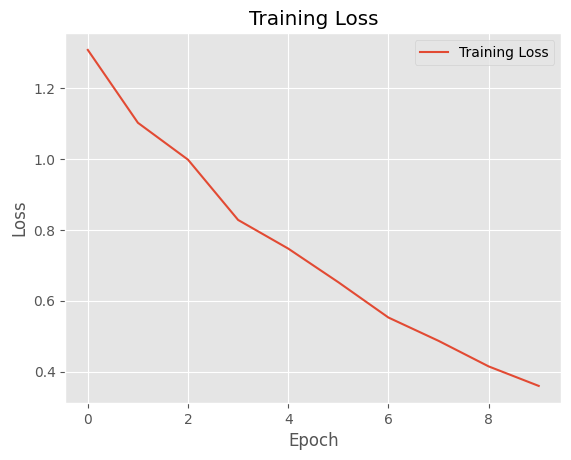

In [186]:
# plot losses and validation accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(range(0, hparams.epochs), wmt2016_train_losses, label="Training Loss")
# plt.plot(range(0, hparams.epochs), wmt2016_valid_losses, label="Validation Loss")
# plt.plot(range(0, hparams.epochs), wmt2016_valid_perplexities, label="Validation Perplexity")
# plt.plot(range(0, hparams.epochs), wmt2016_valid_bleus, label="Validation BLEU")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Training Loss")
plt.show()

In [125]:
# Load best model
wmt_transformer_model_ft.load_parameters(model_filename_ft)

wmt2016_test_loss, wmt2016_test_translation_out = transformer_model.evaluate(
    wmt_transformer_model_ft,
    wmt2016_test_data_loader,
    loss_function,
    wmt_translator_ft,
    wmt_tgt_vocab,
    wmt_detokenizer,
    ctx)

wmt2016_test_bleu_score, _, _, _, _ = nmt.bleu.compute_bleu(
    [wmt2016_test_tgt_sentences],
    wmt2016_test_translation_out,
    tokenized=False,
    tokenizer="13a",
    split_compound_word=False,
    bpe=False)

print('WMT16 test loss: %.2f; test bleu score: %.2f'
      %(wmt2016_test_loss, wmt2016_test_bleu_score * 100))

  0%|          | 0/184 [00:00<?, ?it/s]

WMT16 test loss: 1.23; test bleu score: 26.05


In [114]:
reload(transformer_model)

print("Qualitative Evaluation: Translating from English to German")

# From Google Translate
expected_tgt_seq = "Ich lerne jeden Tag neue Dinge."
print("Expected translation:")
print(expected_tgt_seq)

src_seq = "I learn new things every day."
print("In English:")
print(src_seq)

# translation_out = nmt.utils.translate_with_unk(
# translation_out = nmt.utils.translate(
translation_out = transformer_model.translate(
    wmt_translator_ft,
    src_seq,
    # wmt2016_train_data.src_vocab,
    # wmt2016_train_data.tgt_vocab,
    wmt_src_vocab,
    wmt_tgt_vocab,
    wmt_detokenizer,
    ctx)

print("The German translation is:")
print(" ".join(translation_out[0]))

Qualitative Evaluation: Translating from English to German
Expected translation:
Ich lerne jeden Tag neue Dinge.
In English:
I learn new things every day.
The German translation is:
Ich lerne jedes Mal Neues.


## Fine-Tuning (directly)

In [187]:
ctx = mx.gpu()

# Build on top of Pre-Trained model
wmt_model_name = 'transformer_en_de_512'
wmt_transformer_model_ft_direct, _, _ = nlp.model.get_model(
    wmt_model_name,
    dataset_name='WMT2014',
    pretrained=True,
    ctx=ctx)

# No need to re-configure last layer, just re-initialize
# wmt_transformer_model_ft_direct.tgt_proj = mx.gluon.nn.Dense(units=len(wmt_tgt_vocab), flatten=False, prefix='tgt_proj_')
wmt_transformer_model_ft_direct.tgt_proj.initialize(ctx=ctx)

wmt_transformer_model_ft_direct.hybridize()

model_filename_ft_direct = "transformer_en_de_512_ft_direct.params"

/home/andreto/.local/lib/python3.8/site-packages/gluonnlp/vocab/vocab.py:590: UserWarning: Detected a corrupted index in the deserialize vocabulary. For versions before GluonNLP v0.7 the index is corrupted by specifying the same token for different special purposes, for example eos_token == padding_token. Deserializing the vocabulary nevertheless.
  warnings.warn(
/home/andreto/.local/lib/python3.8/site-packages/mxnet/gluon/parameter.py:896: UserWarning: Parameter 'transformer_src_embed_embedding0_weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/andreto/.local/lib/python3.8/site-packages/mxnet/gluon/parameter.py:896: UserWarning: Parameter 'transformer_src_embed_embedding0_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)


In [188]:
wmt_translator_ft_direct = nmt.translation.BeamSearchTranslator(
    model=wmt_transformer_model_ft_direct,
    beam_size=hparams.beam_size,
    scorer=nlp.model.BeamSearchScorer(alpha=hparams.lp_alpha, K=hparams.lp_k),
    max_length=200)

In [189]:
hparams.epochs = 10
hparams.lr = 0.00003

loss_function = nlp.loss.MaskedSoftmaxCELoss()
loss_function.hybridize(static_alloc=True)

wmt_detokenizer = nlp.data.SacreMosesDetokenizer()

In [190]:
reload(transformer_model)

# Let's train
trainer = mx.gluon.Trainer(wmt_transformer_model_ft_direct.collect_params(), hparams.optimizer, {'learning_rate': hparams.lr})

best_valid_bleu = 0.0

wmt2016_train_losses = []
wmt2016_valid_losses = []
wmt2016_valid_bleus  = []
wmt2016_valid_perplexities = []

for epoch_id in tqdm(range(hparams.epochs)):

    acc_train_loss_batch = 0
    log_loss = 0
    log_denom = 0
    log_avg_gnorm = 0
    log_wc = 0
    log_start_time = time.time()

    # Iterate through each batch
    for batch_id, (src_seq, tgt_seq, src_valid_length, tgt_valid_length) in enumerate(tqdm(wmt2016_train_data_loader)):
        
        src_seq = src_seq.as_in_context(ctx)
        tgt_seq = tgt_seq.as_in_context(ctx)
        src_valid_length = src_valid_length.as_in_context(ctx)
        tgt_valid_length = tgt_valid_length.as_in_context(ctx)
        
        with mx.autograd.record():
            out, _ = wmt_transformer_model_ft_direct(
                src_seq,
                tgt_seq[:, :-1],
                src_valid_length,
                tgt_valid_length - 1)

            loss = loss_function(out, tgt_seq[:, 1:], tgt_valid_length - 1).mean()
            loss = loss * (tgt_seq.shape[1] - 1)
            log_loss += loss * tgt_seq.shape[0]
            log_denom += (tgt_valid_length - 1).sum()
            loss = loss / (tgt_valid_length - 1).mean()
            loss.backward()

        grads = [p.grad(ctx) for p in wmt_transformer_model_ft_direct.collect_params().values() if p.grad_req != 'null']
        gnorm = mx.gluon.utils.clip_global_norm(grads, hparams.clip)
        trainer.step(1)
        
        src_wc = src_valid_length.sum().asscalar()
        tgt_wc = (tgt_valid_length - 1).sum().asscalar()
        log_loss = log_loss.asscalar()
        log_denom = log_denom.asscalar()
        log_avg_gnorm += gnorm
        log_wc += src_wc + tgt_wc
        
        train_loss = log_loss / log_denom
        acc_train_loss_batch += train_loss
        
        if (batch_id + 1) % hparams.log_interval == 0:
            wps = log_wc / (time.time() - log_start_time)
            print("[Epoch {} Batch {}/{}] loss={:.4f}, ppl={:.4f}, gnorm={:.4f}, "
                         "throughput={:.2f}K wps, wc={:.2f}K"
                         .format(epoch_id, batch_id + 1, len(wmt2016_train_data_loader),
                                 train_loss,
                                 np.exp(log_loss / log_denom),
                                 log_avg_gnorm / hparams.log_interval,
                                 wps / 1000, log_wc / 1000))
            
            log_start_time = time.time()
            log_loss = 0
            log_denom = 0
            log_avg_gnorm = 0
            log_wc = 0

    wmt2016_train_loss = acc_train_loss_batch / len(wmt2016_train_data_loader)
    wmt2016_train_losses.append(wmt2016_train_loss)
    
    # Validation step
    wmt2016_valid_loss, wmt2016_valid_translation_out = transformer_model.evaluate(
        wmt_transformer_model_ft_direct,
        wmt2016_val_data_loader,
        loss_function,
        wmt_translator_ft_direct,
        # wmt2016_train_data.tgt_vocab,
        wmt_tgt_vocab,
        wmt_detokenizer,
        ctx)
    
    wmt2016_valid_bleu_score, _, _, _, _ = nmt.bleu.compute_bleu(
        [wmt2016_val_tgt_sentences],
        wmt2016_valid_translation_out,
        tokenized=False,
        tokenizer="13a",
        split_compound_word=False,
        bpe=False)

    wmt2016_valid_perplexity = np.exp(wmt2016_valid_loss)
    wmt2016_valid_perplexities.append(wmt2016_valid_perplexity)
    wmt2016_valid_losses.append(wmt2016_valid_loss)
    wmt2016_valid_bleus.append(wmt2016_valid_bleu_score * 100)
    
    print("[Epoch {}] valid Loss={:.4f}, valid ppl={:.4f}, valid bleu={:.2f}"
          .format(epoch_id, wmt2016_valid_loss, wmt2016_valid_perplexity, wmt2016_valid_bleu_score * 100))
    
    if wmt2016_valid_bleu_score > best_valid_bleu:
        best_valid_bleu = wmt2016_valid_bleu_score
        print("Save best parameters to {}".format(model_filename_ft_direct))
        wmt_transformer_model_ft_direct.save_parameters(model_filename_ft_direct)
    
    # if epoch_id + 1 >= (hparams.epochs * 2) // 3:
    #     new_lr = trainer.learning_rate * hparams.lr_update_factor
    #     print("Learning rate change to {}".format(new_lr))
    #     trainer.set_learning_rate(new_lr)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 0 Batch 100/226] loss=1.4818, ppl=4.4009, gnorm=4.4320, throughput=6.46K wps, wc=38.40K
[Epoch 0 Batch 200/226] loss=1.4594, ppl=4.3032, gnorm=4.5339, throughput=6.63K wps, wc=37.60K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 1 Batch 100/226] loss=1.2766, ppl=3.5845, gnorm=4.2499, throughput=6.58K wps, wc=37.89K
[Epoch 1 Batch 200/226] loss=1.2379, ppl=3.4482, gnorm=4.2953, throughput=6.60K wps, wc=37.80K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 2 Batch 100/226] loss=1.0743, ppl=2.9281, gnorm=3.9684, throughput=6.78K wps, wc=38.12K
[Epoch 2 Batch 200/226] loss=1.1251, ppl=3.0805, gnorm=4.2989, throughput=6.65K wps, wc=37.52K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 3 Batch 100/226] loss=0.9730, ppl=2.6460, gnorm=4.0081, throughput=6.20K wps, wc=38.24K
[Epoch 3 Batch 200/226] loss=0.9646, ppl=2.6237, gnorm=4.0554, throughput=6.63K wps, wc=37.58K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 4 Batch 100/226] loss=0.8541, ppl=2.3493, gnorm=4.0030, throughput=6.68K wps, wc=37.54K
[Epoch 4 Batch 200/226] loss=0.8544, ppl=2.3500, gnorm=4.0174, throughput=6.53K wps, wc=38.53K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 5 Batch 100/226] loss=0.7550, ppl=2.1276, gnorm=3.9647, throughput=6.67K wps, wc=38.03K
[Epoch 5 Batch 200/226] loss=0.7450, ppl=2.1064, gnorm=3.9991, throughput=6.65K wps, wc=38.17K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 6 Batch 100/226] loss=0.6489, ppl=1.9134, gnorm=3.8105, throughput=6.61K wps, wc=38.24K
[Epoch 6 Batch 200/226] loss=0.6584, ppl=1.9316, gnorm=3.9389, throughput=6.61K wps, wc=38.29K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 7 Batch 100/226] loss=0.5615, ppl=1.7533, gnorm=3.6398, throughput=6.59K wps, wc=37.98K
[Epoch 7 Batch 200/226] loss=0.5819, ppl=1.7893, gnorm=3.8930, throughput=6.71K wps, wc=38.02K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 8 Batch 100/226] loss=0.5100, ppl=1.6653, gnorm=3.6705, throughput=6.77K wps, wc=38.19K
[Epoch 8 Batch 200/226] loss=0.4960, ppl=1.6421, gnorm=3.6656, throughput=6.66K wps, wc=37.88K


  0%|          | 0/226 [00:00<?, ?it/s]

[Epoch 9 Batch 100/226] loss=0.4276, ppl=1.5336, gnorm=3.4199, throughput=6.74K wps, wc=38.35K
[Epoch 9 Batch 200/226] loss=0.4396, ppl=1.5521, gnorm=3.7138, throughput=6.64K wps, wc=37.73K


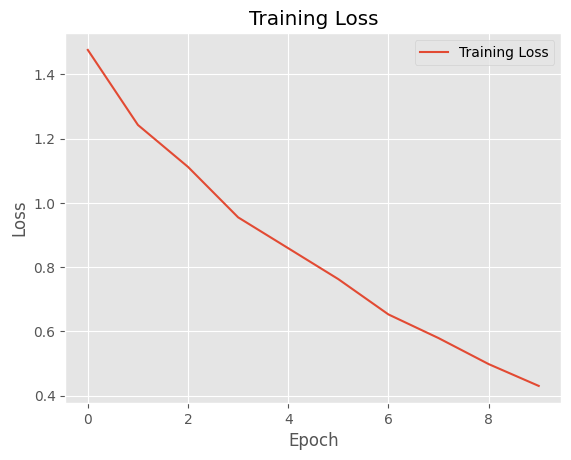

In [191]:
# plot losses and validation accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(range(0, hparams.epochs), wmt2016_train_losses, label="Training Loss")
# plt.plot(range(0, hparams.epochs), wmt2016_valid_losses, label="Validation Loss")
# plt.plot(range(0, hparams.epochs), wmt2016_valid_perplexities, label="Validation Perplexity")
# plt.plot(range(0, hparams.epochs), wmt2016_valid_bleus, label="Validation BLEU")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Training Loss")
plt.show()

In [120]:
# Load best model
wmt_transformer_model_ft_direct.load_parameters(model_filename_ft_direct)

wmt2016_test_loss, wmt2016_test_translation_out = transformer_model.evaluate(
    wmt_transformer_model_ft_direct,
    wmt2016_test_data_loader,
    loss_function,
    wmt_translator_ft_direct,
    wmt_tgt_vocab,
    wmt_detokenizer,
    ctx)

wmt2016_test_bleu_score, _, _, _, _ = nmt.bleu.compute_bleu(
    [wmt2016_test_tgt_sentences],
    wmt2016_test_translation_out,
    tokenized=False,
    tokenizer="13a",
    split_compound_word=False,
    bpe=False)

print('WMT16 test loss: %.2f; test bleu score: %.2f'
      %(wmt2016_test_loss, wmt2016_test_bleu_score * 100))

  0%|          | 0/184 [00:00<?, ?it/s]

WMT16 test loss: 1.22; test bleu score: 26.75


In [124]:
reload(transformer_model)

print("Qualitative Evaluation: Translating from English to German")

# From Google Translate
expected_tgt_seq = "Ich lerne jeden Tag neue Dinge."
print("Expected translation:")
print(expected_tgt_seq)

src_seq = "I learn new things every day."
print("In English:")
print(src_seq)

# translation_out = nmt.utils.translate_with_unk(
# translation_out = nmt.utils.translate(
translation_out = transformer_model.translate(
    wmt_translator_ft_direct,
    src_seq,
    # wmt2016_train_data.src_vocab,
    # wmt2016_train_data.tgt_vocab,
    wmt_src_vocab,
    wmt_tgt_vocab,
    wmt_detokenizer,
    ctx)

print("The German translation is:")
print(" ".join(translation_out[0]))

Qualitative Evaluation: Translating from English to German
Expected translation:
Ich lerne jeden Tag neue Dinge.
In English:
I learn new things every day.
The German translation is:
Ich lerne jedes Mal neue Dinge
